In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_ind
import matplotlib.gridspec as gridspec
import mne
from matplotlib import ticker
import statsmodels.formula.api as smf


In [2]:
behav_df = pd.read_csv('/home/qmoreau/Documents/Beta_bursts/Behavioral/behav_df_cleaned_new.csv')

# Load df_mask correctly, removing the extra index column
df_mask = pd.read_csv('/home/qmoreau/Documents/Beta_bursts/Behavioral/behav_df_mask.csv', index_col=0)

# Ensure we are using the correct boolean column
df_mask = df_mask.iloc[:, 0]  # Select the first column, which is boolean

# Apply the mask correctly
behav_df = behav_df[df_mask.values]

burst_df = pd.read_csv('/home/qmoreau/Documents/Beta_bursts/Burst files/burst_features.csv')

In [3]:
waveform_array_file = '/home/qmoreau/Documents/Beta_bursts/Burst files/all_waveforms.npy'
waveform_array = np.load(waveform_array_file)
waveform_time = np.linspace(-.13, .13, num=156)

In [4]:
lookup_df = behav_df[["coh_cat", "perturb_cat", "trial", "block", "subject", "group"]]
df_burst_behav = burst_df.merge(
    lookup_df, 
    on=["trial", "block", "subject"], 
    how='left'
)

implicit_subjects = behav_df[behav_df['group'] == 'Implicit']['subject'].unique()
explicit_subjects = behav_df[behav_df['group'] == 'Explicit']['subject'].unique()

In [5]:
mask_motor_implicit = (
    (df_burst_behav["epoch"] == "mot") &
    (df_burst_behav["subject"].isin(implicit_subjects))
)
waveform_array_implicit_motor = waveform_array[mask_motor_implicit, :]

# Create one combined mask for "motor" + group=1
mask_motor_explicit = (
    (df_burst_behav["epoch"] == "mot") &
    (df_burst_behav["subject"].isin(explicit_subjects))
)
waveform_array_explicit_motor = waveform_array[mask_motor_explicit, :]

In [6]:
import dask.array as da

def dask_snr(a, axis=0, ddof=0, chunks='auto'):
    
    # Convert to Dask array
    a_dask = da.from_array(a, chunks=chunks)
    
    # Calculate mean and standard deviation
    m = a_dask.mean(axis=axis)
    sd = a_dask.std(axis=axis, ddof=ddof)
    
    # Calculate SNR
    snr = da.where(sd == 0, 0, m / sd)
    
    # Compute and return as numpy array
    return snr.compute()

# Use the Dask version
SNR = dask_snr(waveform_array, axis=0, ddof=1)

In [8]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

SNR = signaltonoise(waveform_array, axis=0, ddof=1)

In [9]:
mean_waveform_implicit_motor = waveform_array_implicit_motor.mean(axis=0)
mean_waveform_explicit_motor = waveform_array_explicit_motor.mean(axis=0)

SNR_implicit_motor = signaltonoise(waveform_array_implicit_motor, axis=0, ddof=1)
SNR_explicit_motor = signaltonoise(waveform_array_explicit_motor, axis=0, ddof=1)

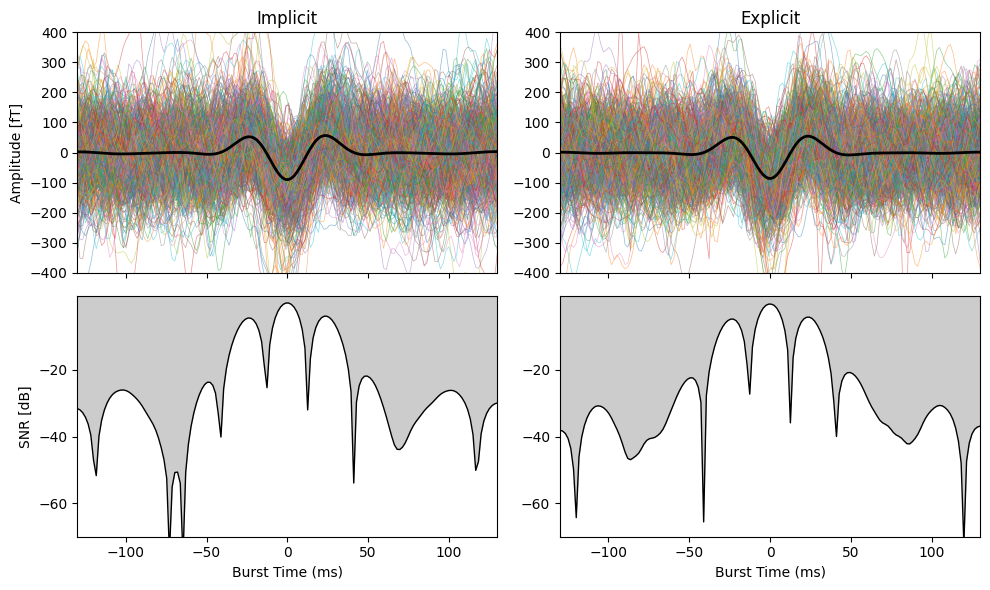

In [10]:
# Convert time to ms
waveform_time_ms = waveform_time * 1000

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True)

# --- LEFT COLUMN = IMPLICIT MOTOR ---
# 1) Waveforms
ax_top_left = axes[0, 0]
ax_top_left.plot(
    waveform_time_ms,
    waveform_array_implicit_motor[::5000].T / 1e-15,  # downsample if needed
    lw=0.5, alpha=0.5
)
ax_top_left.plot(
    waveform_time_ms,
    mean_waveform_implicit_motor / 1e-15,
    lw=2, color="black"
)
ax_top_left.set_ylim(-400, 400)
ax_top_left.set_xlim(-130, 130)
ax_top_left.set_ylabel("Amplitude [fT]")
ax_top_left.set_title("Implicit")

# 2) SNR
ax_bot_left = axes[1, 0]
ax_bot_left.fill_between(
    waveform_time_ms,
    np.zeros_like(waveform_time_ms)+2,
    10 * np.log10(SNR_implicit_motor**2),
    lw=0, color="black", alpha=0.2
)
ax_bot_left.plot(
    waveform_time_ms,
    10 * np.log10(SNR_implicit_motor**2),
    lw=1, color="black"
)
ax_bot_left.set_ylim(-70, 2)
ax_bot_left.set_xlim(-130, 130)
ax_bot_left.set_ylabel("SNR [dB]")
ax_bot_left.set_yticks([-20, -40, -60])
ax_bot_left.set_xlabel("Burst Time (ms)")

# --- RIGHT COLUMN = EXPLICIT MOTOR ---
# 1) Waveforms
ax_top_right = axes[0, 1]
ax_top_right.plot(
    waveform_time_ms,
    waveform_array_explicit_motor[::5000].T / 1e-15,
    lw=0.5, alpha=0.5
)
ax_top_right.plot(
    waveform_time_ms,
    mean_waveform_explicit_motor / 1e-15,
    lw=2, color="black"
)
ax_top_right.set_ylim(-400, 400)
ax_top_right.set_xlim(-130, 130)
ax_top_right.set_title("Explicit")

# 2) SNR
ax_bot_right = axes[1, 1]
ax_bot_right.fill_between(
    waveform_time_ms,
    np.zeros_like(waveform_time_ms)+2,
    10 * np.log10(SNR_explicit_motor**2),
    lw=0, color="black", alpha=0.2
)
ax_bot_right.plot(
    waveform_time_ms,
    10 * np.log10(SNR_explicit_motor**2),
    lw=1, color="black"
)
ax_bot_right.set_ylim(-70, 2)
ax_bot_right.set_xlim(-130, 130)
ax_bot_right.set_yticks([-20, -40, -60])
ax_bot_right.set_xlabel("Burst Time (ms)")

plt.tight_layout()
plt.show()


In [11]:
df_burst_behav_implicit = df_burst_behav[df_burst_behav["group"] == "Implicit"]
df_burst_behav_explicit = df_burst_behav[df_burst_behav["group"] == "Explicit"]

In [12]:

df_burst_behav_implicit["group"] = "Implicit"
df_burst_behav_explicit["group"] = "Explicit"

# Now filter each subset so that epoch == 'mot'
df_burst_behav_implicit_mot = df_burst_behav_implicit[
    df_burst_behav_implicit["epoch"] == "mot"
].copy()

df_burst_behav_explicit_mot = df_burst_behav_explicit[
    df_burst_behav_explicit["epoch"] == "mot"
].copy()

# Concatenate
df_lmm = pd.concat([df_burst_behav_implicit_mot, df_burst_behav_explicit_mot], 
                   ignore_index=True)

/tmp/ipykernel_30760/3174307440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_burst_behav_implicit["group"] = "Implicit"
/tmp/ipykernel_30760/3174307440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_burst_behav_explicit["group"] = "Explicit"


In [13]:
palette0 = sns.color_palette("magma_r", 3)
palette1 = sns.color_palette("mako_r", 3)

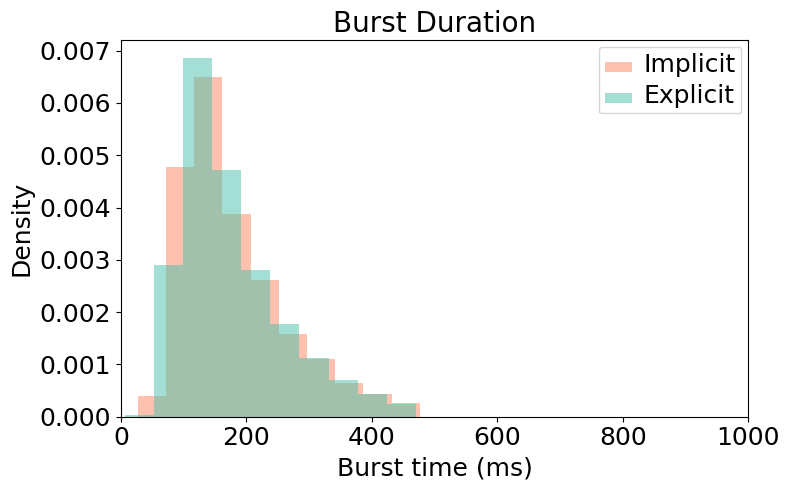

In [14]:
# Extract the burst duration data and convert to milliseconds
fwhm_implicit = df_burst_behav_implicit.loc[
    df_burst_behav_implicit["epoch"] == "mot", 
    "fwhm_time"
].copy() * 1000

fwhm_explicit = df_burst_behav_explicit.loc[
    df_burst_behav_explicit["epoch"] == "mot", 
    "fwhm_time"
].copy() * 1000

# Remove 4 SD outliers
fwhm_implicit_clean = fwhm_implicit[
    (np.abs(fwhm_implicit - fwhm_implicit.mean()) < 3 * fwhm_implicit.std())
]
fwhm_explicit_clean = fwhm_explicit[
    (np.abs(fwhm_explicit - fwhm_explicit.mean()) < 3 * fwhm_explicit.std())
]

# Create a figure with a single axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot both histograms on the same axis with slight transparency
ax.hist(
    fwhm_implicit_clean,
    bins=10,
    color=palette0[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Implicit"
)
ax.hist(
    fwhm_explicit_clean,
    bins=10,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Explicit"
)

ax.set_title("Burst Duration", fontsize=20)
ax.set_xlabel("Burst time (ms)", fontsize=18)
ax.set_ylabel("Density", fontsize=18)
ax.set_xlim(0, 1000)
ax.legend()

# All text is black and font size 18
plt.setp(ax.get_xticklabels(), fontsize=18, color="black")
plt.setp(ax.get_yticklabels(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_texts(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_title(), fontsize=18, color="black")

plt.tight_layout()
plt.show()


In [15]:

# Convert group to a categorical variable if desired
df_lmm["group"] = df_lmm["group"].astype("category")

# df_lmm = df_lmm[df_lmm["fwhm_time"] < (df_lmm["fwhm_time"].mean() + 3 * df_lmm["fwhm_time"].std())]


model = smf.mixedlm(
    formula="fwhm_time ~ group", 
    data=df_lmm, 
    groups=df_lmm["subject"]  # random intercept for subject
)

result = model.fit()
print(result.summary())

subject_means = (
    df_lmm
    .groupby(["subject", "group"], as_index=False)
    ["fwhm_time"]
    .mean()
)


subject_means.dropna(subset=["fwhm_time"], inplace=True)

# do a independent t-test to compare the means of the two groups
t, p = ttest_ind(
    subject_means.query("group == 'Implicit'")["fwhm_time"],
    subject_means.query("group == 'Explicit'")["fwhm_time"],
    equal_var=False
)

print(f"t = {t:.3f}, p = {p:.3f}")


/home/qmoreau/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/qmoreau/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: fwhm_time   
No. Observations: 6506380  Method:             REML        
No. Groups:       37       Scale:              0.0093      
Min. group size:  116784   Log-Likelihood:     5995476.4031
Max. group size:  207473   Converged:          Yes         
Mean group size:  175848.1                                 
-----------------------------------------------------------
                   Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept          0.183    0.023 8.055 0.000  0.138  0.227
group[T.Implicit]  0.004    0.032 0.128 0.899 -0.058  0.066
Group Var          0.009                                   



/tmp/ipykernel_30760/177906891.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["subject", "group"], as_index=False)


t = 1.050, p = 0.302


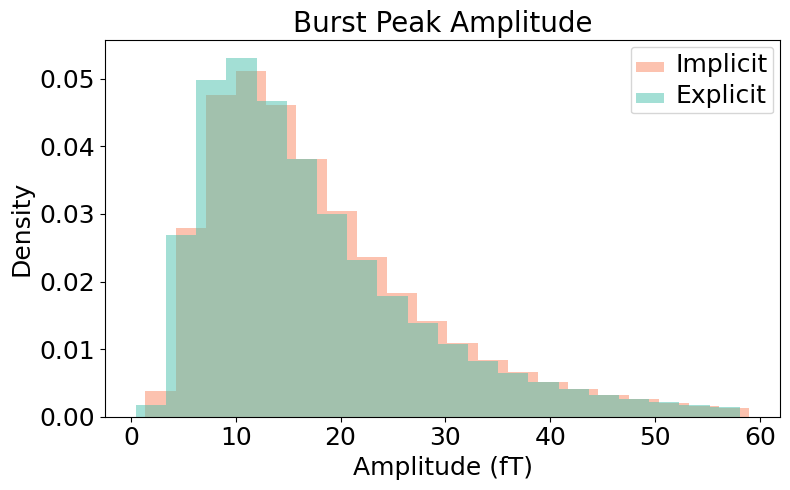

In [16]:

peak_amp_base_implicit = df_burst_behav_implicit.loc[
    df_burst_behav_implicit["epoch"] == "mot", 
    "peak_amp_base"
].copy()

peak_amp_base_explicit = df_burst_behav_explicit.loc[
    df_burst_behav_explicit["epoch"] == "mot", 
    "peak_amp_base"
].copy()

# drop 3 sd outliers
peak_amp_base_implicit = peak_amp_base_implicit[peak_amp_base_implicit < peak_amp_base_implicit.mean() + 3*peak_amp_base_implicit.std()] * 1e15
peak_amp_base_explicit = peak_amp_base_explicit[peak_amp_base_explicit < peak_amp_base_explicit.mean() + 3*peak_amp_base_explicit.std()] * 1e15

# linspace to have same bins
33
# Create a figure with a single axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot both histograms on the same axis with slight transparency
ax.hist(
    peak_amp_base_implicit, bins=20, alpha=0.5, density=True, label="Implicit", color=palette0[0],
)
ax.hist(
    peak_amp_base_explicit, bins=20, alpha=0.5, density=True, label="Explicit", color=palette1[0],
)
ax.set_title("Burst Peak Amplitude", fontsize=20)
ax.set_xlabel("Amplitude (fT)", fontsize=18)
ax.set_ylabel("Density", fontsize=18)
# ax.set_xlim(0, 0.25e-12)
ax.legend()

# all text is black and 18
plt.setp(ax.get_xticklabels(), fontsize=18, color="black")
plt.setp(ax.get_yticklabels(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_texts(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_title(), fontsize=18, color="black")


plt.tight_layout()
plt.show()

In [17]:

model = smf.mixedlm(
    formula="peak_amp_base ~ group", 
    data=df_lmm, 
    groups=df_lmm["subject"]  # random intercept for subject
)

result = model.fit()
print(result.summary())

subject_means = (
    df_lmm
    .groupby(["subject", "group"], as_index=False)
    ["peak_amp_base"]
    .mean()
)

subject_means.dropna(subset=["peak_amp_base"], inplace=True)

# do a independent t-test to compare the means of the two groups
t, p = ttest_ind(
    subject_means.query("group == 'Implicit'")["peak_amp_base"],
    subject_means.query("group == 'Explicit'")["peak_amp_base"],
    equal_var=False
)

print(f"t = {t:.3f}, p = {p:.3f}")

/home/qmoreau/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/qmoreau/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: peak_amp_base 
No. Observations: 6506380  Method:             REML          
No. Groups:       37       Scale:              0.0000        
Min. group size:  116784   Log-Likelihood:     199270396.3373
Max. group size:  207473   Converged:          Yes           
Mean group size:  175848.1                                   
-------------------------------------------------------------
                     Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept            0.000    0.000 6.515 0.000  0.000  0.000
group[T.Implicit]    0.000    0.000 0.235 0.814 -0.000  0.000
Group Var            0.000                                   



/tmp/ipykernel_30760/4126443523.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["subject", "group"], as_index=False)


t = 0.508, p = 0.615


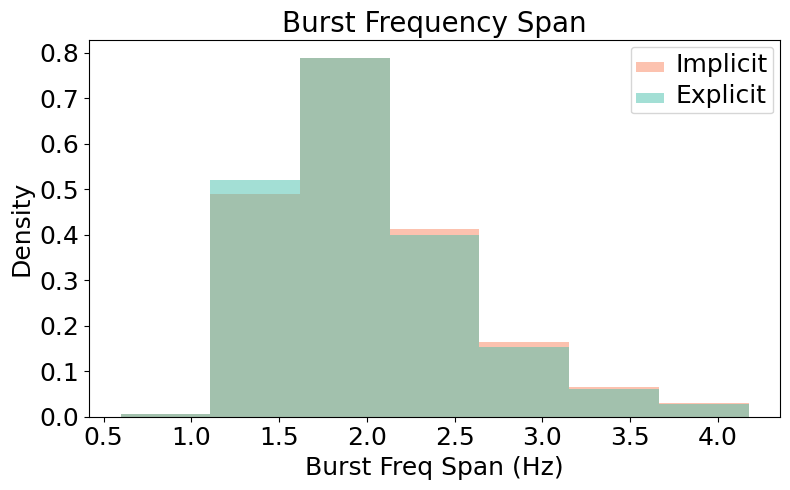

In [18]:

# Extract the burst duration data

fwhm_freq_implicit = df_burst_behav_implicit.loc[
    df_burst_behav_implicit["epoch"] == "mot", 
    "fwhm_freq"
].copy()

fwhm_freq_explicit = df_burst_behav_explicit.loc[
    df_burst_behav_explicit["epoch"] == "mot", 
    "fwhm_freq"
].copy()

# remove 4 sd outliers
fwhm_freq_implicit = fwhm_freq_implicit[(np.abs(fwhm_freq_implicit - fwhm_freq_implicit.mean()) < 3 * fwhm_freq_implicit.std())]
fwhm_freq_explicit = fwhm_freq_explicit[(np.abs(fwhm_freq_explicit - fwhm_freq_explicit.mean()) < 3 * fwhm_freq_explicit.std())]

# Create a figure with a single axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot both histograms on the same axis with slight transparency
ax.hist(
    fwhm_freq_implicit,
    bins=7,
    color=palette0[0],
    alpha=0.5,             
    linewidth=0.2,
    density=True,          
    label="Implicit"
)
ax.hist(
    fwhm_freq_explicit,
    bins=7,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Explicit"
)

ax.set_title("Burst Frequency Span", fontsize=20)
ax.set_xlabel("Burst Freq Span (Hz)", fontsize=18)
ax.set_ylabel("Density", fontsize=18)
# ax.set_xlim(0, 1)
ax.legend()

# all text is black and 18
plt.setp(ax.get_xticklabels(), fontsize=18, color="black")
plt.setp(ax.get_yticklabels(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_texts(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_title(), fontsize=18, color="black")

plt.tight_layout()
plt.show()

In [19]:
model = smf.mixedlm(
    formula="fwhm_freq ~ group", 
    data=df_lmm, 
    groups=df_lmm["subject"]  # random intercept for subject
)

result = model.fit()
print(result.summary())


subject_means = (
    df_lmm
    .groupby(["subject", "group"], as_index=False)
    ["fwhm_freq"]
    .mean()
)

subject_means.dropna(subset=["fwhm_freq"], inplace=True)

# do a independent t-test to compare the means of the two groups
t, p = ttest_ind(
    subject_means.query("group == 'Implicit'")["fwhm_freq"],
    subject_means.query("group == 'Explicit'")["fwhm_freq"],
    equal_var=False
)

print(f"t = {t:.3f}, p = {p:.3f}")

/home/qmoreau/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: fwhm_freq    
No. Observations: 6506380  Method:             REML         
No. Groups:       37       Scale:              0.6640       
Min. group size:  116784   Log-Likelihood:     -7900295.0536
Max. group size:  207473   Converged:          Yes          
Mean group size:  175848.1                                  
------------------------------------------------------------
                   Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          1.994    0.192 10.384 0.000  1.618  2.371
group[T.Implicit]  0.034    0.268  0.126 0.900 -0.492  0.559
Group Var          0.664                                    



/tmp/ipykernel_30760/3402401548.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["subject", "group"], as_index=False)


t = 1.209, p = 0.236


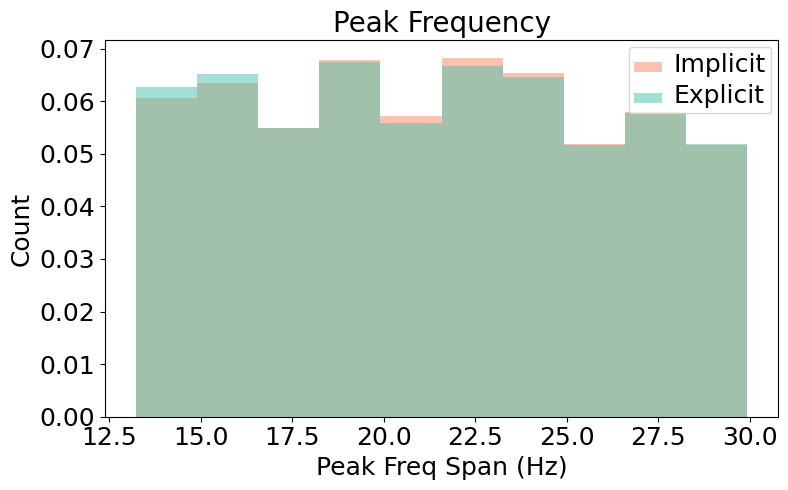

In [20]:

# Extract the burst duration data
peak_freq_implicit = df_burst_behav_implicit["peak_freq"]
peak_freq_explicit = df_burst_behav_explicit["peak_freq"]

# remove 4 sd outliers
peak_freq_implicit = peak_freq_implicit[(np.abs(peak_freq_implicit - peak_freq_implicit.mean()) < 73 * peak_freq_implicit.std())]
peak_freq_explicit = peak_freq_explicit[(np.abs(peak_freq_explicit - peak_freq_explicit.mean()) < 3 * peak_freq_explicit.std())]

# Create a figure with a single axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot both histograms on the same axis with slight transparency
ax.hist(
    peak_freq_implicit,
    bins=10,
    color=palette0[0],
    alpha=0.5,              # transparency
    linewidth=0.2,
    density=True,          
    label="Implicit"
)
ax.hist(
    peak_freq_explicit,
    bins=10,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Explicit"
)

ax.set_title("Peak Frequency", fontsize=20)
ax.set_xlabel("Peak Freq Span (Hz)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
# ax.set_xlim(0, 1)
ax.legend()


# all text is black and 18
plt.setp(ax.get_xticklabels(), fontsize=18, color="black")
plt.setp(ax.get_yticklabels(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_texts(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_title(), fontsize=18, color="black")

plt.tight_layout()
plt.show()

In [21]:
model = smf.mixedlm(
    formula="peak_freq ~ group", 
    data=df_lmm, 
    groups=df_lmm["subject"]  # random intercept for subject
)

result = model.fit()
print(result.summary())


subject_means = (
    df_lmm
    .groupby(["subject", "group"], as_index=False)
    ["peak_freq"]
    .mean()
)

subject_means.dropna(subset=["peak_freq"], inplace=True)

# do a independent t-test to compare the means of the two groups
t, p = ttest_ind(
    subject_means.query("group == 'Implicit'")["peak_freq"],
    subject_means.query("group == 'Explicit'")["peak_freq"],
    equal_var=False
)

print(f"t = {t:.3f}, p = {p:.3f}")

/home/qmoreau/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: peak_freq     
No. Observations: 6506380  Method:             REML          
No. Groups:       37       Scale:              22.5895       
Min. group size:  116784   Log-Likelihood:     -19374138.5593
Max. group size:  207473   Converged:          Yes           
Mean group size:  175848.1                                   
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          21.327    1.120 19.038 0.000 19.131 23.523
group[T.Implicit]  -0.030    1.563 -0.019 0.985 -3.094  3.034
Group Var          22.589                                    



/tmp/ipykernel_30760/1958822523.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["subject", "group"], as_index=False)


t = -0.279, p = 0.782


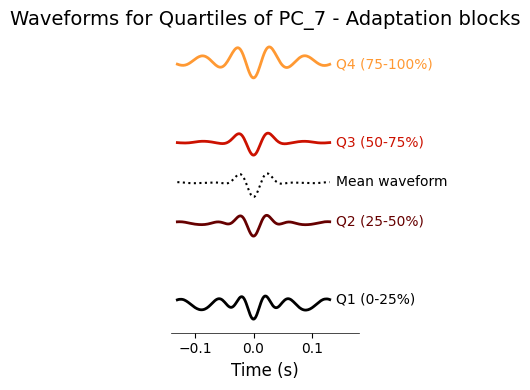

In [33]:
# Create time array for x-axis
waveform_time = np.linspace(-.13, .13, num=156)

# Calculate mean waveform
mean_waveform = np.mean(waveform_array, axis=0)

# Define quartiles (4 equal divisions from 0-100%)
prct = np.linspace(0, 100, num=5)  # [0, 25, 50, 75, 100]
prct_ranges = list(zip(prct[:-1], prct[1:]))  # [(0,25), (25,50), (50,75), (75,100)]

# Create a dictionary to store the waveforms
pc_key = "PC_7"  # We're focusing on PC_7 as requested
wvfrms = []


for low, hi in prct_ranges:
    low_perc = np.percentile(burst_df[pc_key], low)
    hi_perc = np.percentile(burst_df[pc_key], hi)
    
    # Get indices of bursts in this quartile AND in blocks 1-6
    wvf_ixs = burst_df.loc[
        (burst_df[pc_key] >= low_perc) &
        (burst_df[pc_key] <= hi_perc) &
        (burst_df['block'] >= 1) &
        (burst_df['block'] <= 6)
    ].index
    
    # Calculate mean waveform for this quartile
    MWF = np.mean(waveform_array[wvf_ixs, :], axis=0)
    wvfrms.append(MWF)

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(3, 4), facecolor="white")

# Generate a cool colormap for the quartiles (blue to purple)
colors = plt.cm.gist_heat(np.linspace(0, 0.8, num=4))  # Limit the range to avoid white

# Set the title
ax.set_title(f"Waveforms for Quartiles of {pc_key} - Adaptation blocks", fontsize=14)

# Add axes labels
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Amplitude (scaled)", fontsize=12)

# Plot each quartile with proper labeling and formatting
quartile_names = ["Q1 (0-25%)", "Q2 (25-50%)", "Q3 (50-75%)", "Q4 (75-100%)"]
vertical_offset = np.linspace(0, 150, num=4)  # Offset to separate waveforms vertically

for i, waveform in enumerate(wvfrms):
    # Scale and offset the waveform for better visibility
    scaled_waveform = waveform * 1e14 + vertical_offset[i]
    
    # Plot the waveform with appropriate color
    ax.plot(waveform_time, scaled_waveform, c=colors[i], linewidth=2)
    
    # Add label at the end of each waveform
    ax.text(waveform_time[-1] + 0.01, scaled_waveform[-1], quartile_names[i], 
            color=colors[i], fontsize=10, verticalalignment='center')

# Also plot the mean waveform at the bottom
ax.plot(waveform_time, mean_waveform * 1e14 + 75, c="black", lw=1.5, linestyle="dotted")
ax.text(waveform_time[-1] + 0.01, mean_waveform[-1] * 1e14 + 75, 'Mean waveform', 
        color="black", fontsize=10, verticalalignment='center')


# Set x-axis limits to provide a bit of padding
ax.set_xlim(waveform_time[0] - 0.01, waveform_time[-1] + 0.05)

# remove y axis
ax.yaxis.set_visible(False)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)

# Show the plot
plt.tight_layout()
plt.show()